# Thought Process
### Problem Exploration:
* Explore wikipedia pages' structure
* Valid vs invalid links to search (where to find valid links, how to eliminate invalid links)

### Solution method:
* Requested method is closest to DFS (depth first search)
* Each website is a node in the directed graph while links are connections
* Use BeautifulSoup to parse the HTML files obtained

### Evaluation methods:
* Number of nodes searched before reaching goal

### Assumptions due to some vagueness in the task prompt:
* Parentheses are assumed to be "[  ]", this can be changed by chaning the variable rejected_parentheses
* Not in a box is assumed to be any kind of box (i.e. any tables in the main article)
* Links from images are ignored using using the fact that link.text == 0 for links to images
* Footnote is assumed to the footnote of the website
* For simplicity, links are declared italic (and therefore rejected) if its closest parent is of type \<i\>
* This means if only part of the link is italic it is considered as valid
* If the word philosophy is in the title, it is counted as a completion

### Any false assumptions about the validity of the links can be modified by changing is_link_valid or get_page_links functions

In [1]:
%%writefile ./scrape.py
from requests import get
from bs4 import BeautifulSoup
import time

# Module variables
rejected_parentheses = ['[']
sleep_between_searches = 0.5 # in seconds

def is_link_valid(link):
  """ Function tests is a link is valid according to the properties mentioned above
  link is invalid if empty, starts with rejected parenthesis, or has a parent with <i> tag i.e. italic

  Args:
    link (bs4.element.Tag): link object to evaluate its validity 
  
  Returns: 
    bool: True if the link is valid, False otherwise
  """
  fail_conds = []
  fail_conds.append(  len(link.text.lstrip())==0  )
  fail_conds.append(  len(link['href'])==0  )
  fail_conds.append(  len(link.text.lstrip())>0 and link.text.lstrip()[0] in rejected_parentheses  )
  fail_conds.append(  link.parent is not None and link.parent.name == 'i'  )
  fail_conds.append(  len(link['href'])>0 and link['href'][0]=='#'  )
  fail_conds.append(  'wiki/' not in link['href']  )
  return True not in fail_conds
  
def get_page_links(url):
  """ Scrapes a wikipedia url, gathers, and returns all valid links in the page

  Args:
    url (str): A valid wikipedia url

  Returns:
    list of bs4.element.Tag: a list of tags of type <a> that are valid links
  """
  # Get wikipedia page
  try:
    response = get(url)
    assert len(response.text)>0 # Empty article / invalid page
  except:
    print("Error getting {} page! This might result in an incorrect answer! Will try to use other pages.".format(url))
    return []
  
  # Parse webpage, and choose div with mw-parser-output id which contains main body of wikipedia pages
  parsed_webpage = BeautifulSoup(response.text, 'html.parser')
  try:
    parsed_article_body = parsed_webpage.select('div.mw-parser-output')[0]
    assert parsed_article_body is not None
  except: # Couldn't find main body of the article
    return []

  # Get all links and find the valid ones
  valid_links_list = []
  for p in parsed_article_body.find_all(['p','li']):
    new_links_list = p.find_all('a', href=True)
    new_valid_links_list = [link for link in new_links_list if is_link_valid(link)]
    valid_links_list.extend(new_valid_links_list)

  return valid_links_list

def get_is_target_found(links_list,target_name):
  """ Check a link of links for a target

  Args:
    links_list (bs4.element.Tag of type <a>): list of valid links as bs4 <a> tags
    target_name (str): the target name to reach (Ex: "philosophy")

  Returns:
    bool: True if target was found in the given list of links, False otherwise
    link (bs4.element.Tag): the link where the target was found or None if the target wasn't found
  """
  for link in links_list:
      if target_name.lower() == link.text.lower():
        return True,link
  return False,None

def DFS(link_url,link_name,visited_links,target_name,verbose=False):
  """ Recursive function used to search for the target link using depth first search

  Args:
    link_url (str): valid wikipedia url to a link
    link_name (str): name of the wikipedia page whose url was given in link_url
    visited_links (list of str): a list of page names visited (names not urls)
    target_name (str): word to search for (Ex: "philosophy")
    verbose (bool): used for debugging purposes. If True, extra logging is done; if False, no extra logging is done

  Returns:
    bool: True if target_name was found, False if reached loop or dead end
    list of str: a list of all visited links before reaching target or reacing a loop or dead end
  """
  # Get new links from url and record url as visited
  new_links_list = get_page_links(link_url)
  visited_links.append(link_name)

  if verbose: # For debugging, link statistics for current page
    print("{}: has {} links".format(link_name,len(new_links_list)))

  # Check if target is in the new links list
  is_target_found, target_link = get_is_target_found(new_links_list,target_name)
  if is_target_found:
    visited_links.append(target_link.text)
    return True, visited_links

  # Go through links to find the target recursively
  for link in new_links_list:
    if link.text not in visited_links: # a link is new
      time.sleep(sleep_between_searches)
      is_success, visited_links = DFS('https://wikipedia.org/'+link['href'],link.text,visited_links,target_name,verbose=verbose)

      if is_success: # Found target
        return True,visited_links
  
  if verbose and len(new_links_list)==0: # For debugging, reached dead end with no links
    print("Reached dead end with no links at {}. Backing up to a previous link to continue search".format(link_name))
  
  return False,visited_links # Target wasn't found in the given link or any of its children

Writing ./scrape.py


### Unit Tests

In [2]:
%%writefile ./unit_tests.py
import unittest
from scrape import *
import time

# Testing is_link_valid function
class Test_is_link_valid(unittest.TestCase):
  def test_parentheses(self):
    test_examples = [BeautifulSoup('<a href="test/wiki/">[rejected parenthesis]</a>','html.parser').find_all('a')[0], 
                     BeautifulSoup('<a href="test/wiki/">    [rejected with white space]</a>','html.parser').find_all('a')[0],
                     BeautifulSoup('<a href="test/wiki/">(accepted parenthesis)</a>','html.parser').find_all('a')[0]]
    test_answers = [False,False,True]
    for example,answer in zip(test_examples,test_answers):
      self.assertEqual(is_link_valid(example),answer)

  def test_italic_parents(self):
    test_examples = [BeautifulSoup('<i><a href="test/wiki/">Test Italic</a><i>','html.parser').find_all('a')[0],
                     BeautifulSoup('<a href="test/wiki/">Test non Italic</a>','html.parser').find_all('a')[0]]
    test_answers = [False,True]
    for example,answer in zip(test_examples,test_answers):
      self.assertEqual(is_link_valid(example),answer)
  
  def test_empty(self):
    test_examples = [BeautifulSoup('<a href="test/wiki/"></a>','html.parser').find_all('a')[0]]
    test_answers = [False]
    for example,answer in zip(test_examples,test_answers):
      self.assertEqual(is_link_valid(example),answer)

# Testing get_page_links function
class Test_get_page_links(unittest.TestCase):
  def test_random_pages(self):
    num_tests = 10
    for i in range(num_tests):
      new_links = get_page_links('https://wikipedia.org/wiki/Special:Random')

  def test_page_no_links(self):
    # Can be found at https://en.wikipedia.org/wiki/Special:DeadendPages
    test_urls = ['https://en.wikipedia.org/wiki/ASDP_Indonesia_Ferry',
                 'https://en.wikipedia.org/wiki/Anthesphoria',
                 'https://en.wikipedia.org/wiki/Association_of_Governing_Boards_of_Universities_and_Colleges',
                 'https://en.wikipedia.org/wiki/Bonsa_Tyre_Factory']
    for url in test_urls:
      time.sleep(sleep_between_searches)
      new_links = get_page_links(url)
      self.assertEqual(len(new_links),0)
  
  def test_invalid_page(self): # Should print an Error message without throwing an error
    test_urls = ['https://invalid.random.page/']
    for url in test_urls:
      time.sleep(sleep_between_searches)
      new_links = get_page_links(url)
      self.assertEqual(len(new_links),0)

# Testing get_is_target_found function
class Test_get_is_target_found(unittest.TestCase):
  def test_target_upper(self):
    test_examples = [BeautifulSoup('<a href="test/wiki/">Target</a>','html.parser').find_all('a'),
                 BeautifulSoup('<a href="test/wiki/">tArGET</a>','html.parser').find_all('a'),
                 BeautifulSoup('<a href="test/wiki/">tArGEt</a>','html.parser').find_all('a'),
                 BeautifulSoup('<a href="test/wiki/">not here</a>','html.parser').find_all('a')]
    target = 'tarGeT'
    test_answers = [True,True,True,False]
    for example,answer in zip(test_examples,test_answers):
      self.assertEqual(get_is_target_found(example,target)[0],answer)
      


Writing ./unit_tests.py


In [3]:
!python -m unittest unit_tests

.Error getting https://invalid.random.page/ page! This might result in an incorrect answer! Will try to use other pages.
......
----------------------------------------------------------------------
Ran 7 tests in 8.400s

OK


### Integration Tests

In [4]:
from scrape import *

# Testing full framework, 10 random tests
num_tests = 30
num_nodes_to_end = []

for i in range(num_tests):
  is_found,visited_list = DFS('https://en.wikipedia.org/wiki/Special:Random','Special:Random',[],'philosophy',verbose=False)
  if is_found:
    num_nodes_to_end.append(len(visited_list))
    print(visited_list)
  else:
    print("Not found")

['Special:Random', 'Alternative rock', 'Punk rock', 'Garage rock', 'Rock and roll', 'Rhythm and blues', 'Jazz', 'Blues', 'Work songs', 'sea shanties', 'work song', 'street cries', 'medieval period', 'Philosophy']
['Special:Random', 'footballer', 'The Beautiful Game', 'Portuguese', 'Brazilians', 'Brazil', 'Coordinates', 'Geodesy', 'Geodynamics', 'Geomatics', 'History', 'Geographical distance', 'Geoid', 'Figure of the Earth', 'Earth radius', "Earth's circumference", 'distance around', 'Outline', 'Euclidean', 'Non-Euclidean', 'Philosophy']
['Special:Random', 'Imperial College London', 'ACU', 'Commonwealth', 'Antigua and Barbuda', 'Coordinates', 'Geodesy', 'Geodynamics', 'Geomatics', 'History', 'Geographical distance', 'Geoid', 'Figure of the Earth', 'Earth radius', "Earth's circumference", 'distance around', 'Outline', 'Euclidean', 'Non-Euclidean', 'Philosophy']
['Special:Random', 'studio album', 'compact disc', 'Optical disc', 'DRAM', 'SDRAM', 'DDR', 'GDDR', 'HBM', 'SRAM', 'Williams–Kilb

In [5]:
# Testing full framework on dead ends, can be found at https://en.wikipedia.org/wiki/Special:DeadendPages

test_dead_urls = ['https://en.wikipedia.org/wiki/ASDP_Indonesia_Ferry',
                 'https://en.wikipedia.org/wiki/Anthesphoria',
                 'https://en.wikipedia.org/wiki/Association_of_Governing_Boards_of_Universities_and_Colleges',
                 'https://en.wikipedia.org/wiki/Bonsa_Tyre_Factory']

for url in test_dead_urls:
  is_found,visited_list = DFS(url,'Dead link',[],'philosophy',verbose=True)
  if is_found:
    print(visited_list)
  else:
    print("Not found")

Dead link: has 0 links
Reached dead end with no links at Dead link. Backing up to a previous link to continue search
Not found
Dead link: has 0 links
Reached dead end with no links at Dead link. Backing up to a previous link to continue search
Not found
Dead link: has 0 links
Reached dead end with no links at Dead link. Backing up to a previous link to continue search
Not found
Dead link: has 0 links
Reached dead end with no links at Dead link. Backing up to a previous link to continue search
Not found


### Evaluation Results and Insights
* Average number of nodes/websites to search before reaching 'philosophy' is around 
* The variance of it is which is mainly due to outliers

In [6]:
import numpy as np

print("Number of nodes to search has mean = {:.2f} and std = {:.2f})".format(np.mean(num_nodes_to_end),np.std(num_nodes_to_end)))

Number of nodes to search has mean = 17.37 and std = 15.71)


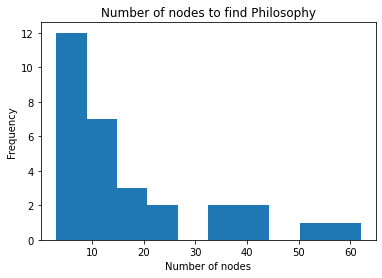

In [7]:
import matplotlib.pyplot as plt

plt.title("Number of nodes to find Philosophy")
plt.xlabel("Number of nodes")
plt.ylabel("Frequency")
plt.hist(num_nodes_to_end)
plt.show()